This notebook is a reproduction of algorythm suggested by:

Avidan, Shai & Shamir, Ariel. (2007). Seam Carving for Content-Aware Image Resizing. SIGGRAPH. 26. 10.1145/1276377.1276390. 

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

The image we'll use:

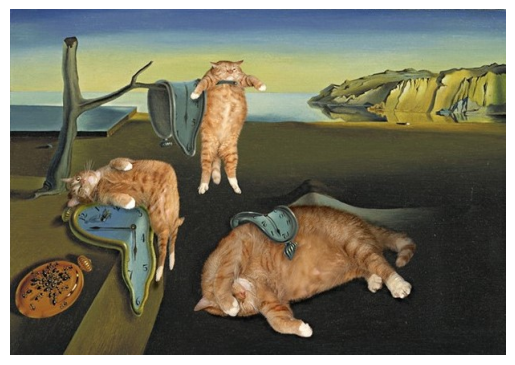

In [ ]:
image = cv2.imread('The_Persistence_of_Memory_cat.jpg')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Let's define the class for image resizing:

In [ ]:
class Seam_Carving_Resizer:

    def __init__(self,path_to_image):
        image = cv2.imread(path_to_image)
        self.grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        self.kernel_w = np.array([[-0.125, 0, 0.125],[-0.25, 0, 0.25],[-0.125, 0, 0.125]]) # Sobel
        self.kernel_h = np.array([[-0.125, -0.25, -0.125],[0, 0, 0],[0.125, 0.25, 0.125]]) # filters
        self.images = [image] 
        self.energy_maps = []
        self.path = []
        self.convolved = []
        self.images_with_path = []
        
    def convolve(self,grayscale_image):
        convolved_h = abs(scipy.signal.convolve2d(grayscale_image,self.kernel_h,'same'))
        convolved_w = abs(scipy.signal.convolve2d(grayscale_image,self.kernel_w,'same'))
        convolved = (convolved_h + convolved_w) / 2
        return convolved
    
    def create_energy_map(self,convolved_image):
        energy = np.zeros_like(convolved_image)
        energy[-1] = convolved_image[-1]
        e_shape = energy.shape
        for i in range(e_shape[0]-2,-1,-1):
            for j in range(e_shape[1]):
                if j > 0 and j < e_shape[1]-1:
                    energy[i,j] = min(energy[i+1,j-1],energy[i+1,j],energy[i+1,j+1]) + convolved_image[i,j]
                elif j == e_shape[1]-1:
                    energy[i,j] = min(energy[i+1,j-1],energy[i+1,j]) + convolved_image[i,j]
                elif j == 0:
                    energy[i,j] = min(energy[i+1,j],energy[i+1,j+1]) + convolved_image[i,j]
        return energy

    def find_best_path(self,energy):
        path = np.zeros(energy.shape[0],dtype=np.int32)
        path[0] = energy[0].argmin()
        e_shape = energy.shape
        for i in range(1,energy.shape[0]):
            if path[i-1] > 0 and path[i-1] < e_shape[1]-2:
                path[i] = path[i-1] + np.argmin(np.array([energy[i,path[i-1]-1], energy[i,path[i-1]], energy[i,path[i-1]+1]])) - 1
            elif path[i-1] == e_shape[1]-2:
                path[i] = path[i-1] + np.argmin(np.array([energy[i,path[i-1]-1], energy[i,path[i-1]]])) - 1
            elif path[i-1] == 0:
                path[i] = path[i-1] + np.argmin(np.array([energy[i,path[i-1]], energy[i,path[i-1]+1]])) + 1
        return path

    def shift_image(self,image,grayscale,energy,path):
        image_new = np.ones([image.shape[0],image.shape[1],image.shape[2]],dtype=np.uint8)*255
        energy_new = np.zeros([energy.shape[0],energy.shape[1]])
        grayscale_new = np.zeros([energy.shape[0],energy.shape[1]])
        for i in range(1,energy.shape[0]):
            image_new[i,:path[i],:] = image[i,:path[i],:]
            image_new[i,path[i]:-1,:] = image[i,path[i]+1:,:]
            energy_new[i,:path[i]] = energy[i,:path[i]]
            energy_new[i,path[i]:-1] = energy[i,path[i]+1:]
            grayscale_new[i,:path[i]] = grayscale[i,:path[i]]
            grayscale_new[i,path[i]:-1] = grayscale[i,path[i]+1:]
        return image_new, grayscale_new[:,:-1]
    
    def draw_path(self,image,path):
        path_visualized = image.copy()
        for i in range(1,path_visualized.shape[0]):
            path_visualized[i,path[i]-1:path[i]+2,0] = 0
            path_visualized[i,path[i]-1:path[i]+2,1] = 0
            path_visualized[i,path[i]-1:path[i]+2,2] = 255
        return path_visualized
        
    def resize(self,n_pixels_to_remove):
        image = self.images[0]
        grayscale_image = self.grayscale_image
        for _ in tqdm(range(n_pixels_to_remove)):
            convolved_image = self.convolve(grayscale_image)
            energy = self.create_energy_map(convolved_image)
            path = self.find_best_path(energy)
            path_visualized = self.draw_path(image,path)
            image, grayscale_image = self.shift_image(image,grayscale_image,energy,path)
            self.convolved.append(convolved_image)
            self.path.append(path)
            self.energy_maps.append(energy)
            self.images_with_path.append(path_visualized)
            self.images.append(image)
        return image
        
    def create_video(self, videoname, num_frames = None, which='original'):
        if which == 'original':
            images = self.images
        elif which == 'with path':
            images = self.images_with_path
        if num_frames:
            images = images[:num_frames]
        height, width, _ = images[0].shape
        video = cv2.VideoWriter(videoname, cv2.VideoWriter_fourcc(*'DIVX'), 10, (width,height))
        for i in tqdm(range(len(images))):
            video.write(images[i])
        video.release()

Let's create a Seam_Carving_Resizer object and use it to get rid of 200 rows of original image:

In [4]:
SCR = Seam_Carving_Resizer('The_Persistence_of_Memory_cat.jpg')
reduced_image = SCR.resize(200)

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Let's visualize the result:

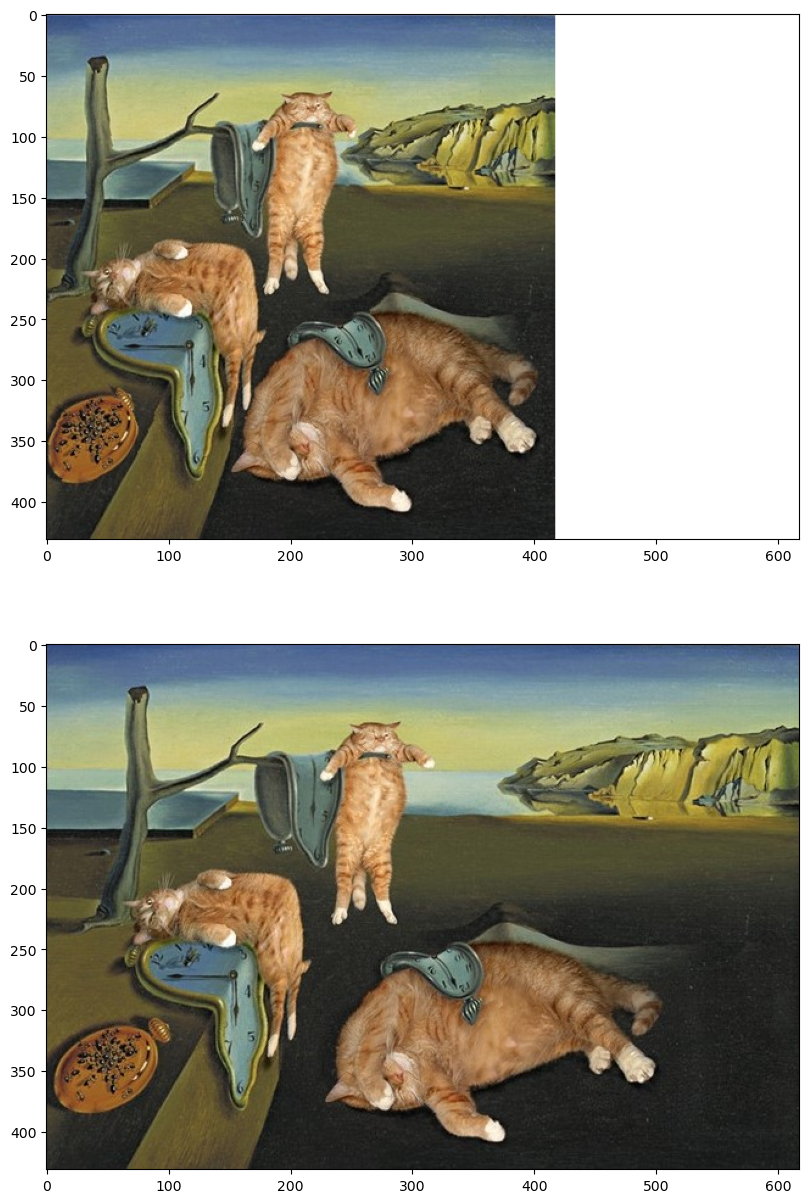

In [7]:
fig, axs = plt.subplots(2,1,figsize=(10,15))
axs[0].imshow(cv2.cvtColor(reduced_image,cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

Let's visualize what we get after convolving original image with Sobel filters:

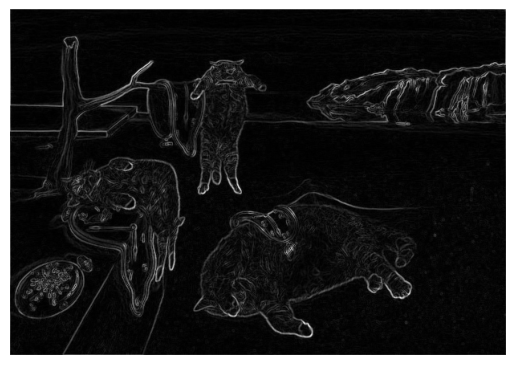

In [11]:
plt.imshow(SCR.convolved[0],cmap='gray')
plt.axis('off')
plt.show()

Let's plot an energy map of an original image:

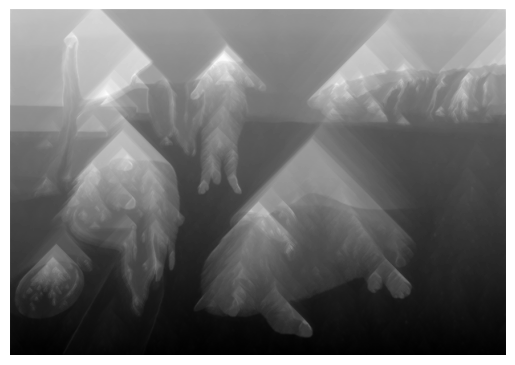

In [13]:
plt.imshow(SCR.energy_maps[0],cmap='gray')
plt.axis('off')
plt.show()

Let's plot the pixels to be removed on the original image:

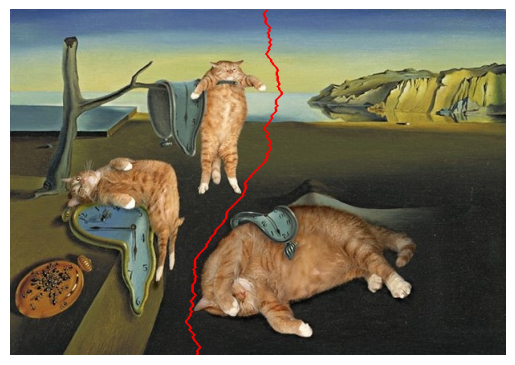

In [15]:
plt.imshow(cv2.cvtColor(SCR.images_with_path[0],cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

And also we can create a video of pixels removal process:

In [17]:
SCR.create_video('The_Persistence_of_Memory_cat_200_original.mp4',num_frames=200,which='original')
SCR.create_video('The_Persistence_of_Memory_cat_200_with_path.mp4',num_frames=200,which='with path')

100%|██████████| 200/200 [00:00<00:00, 214.55it/s]
